## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizontal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/horizontal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


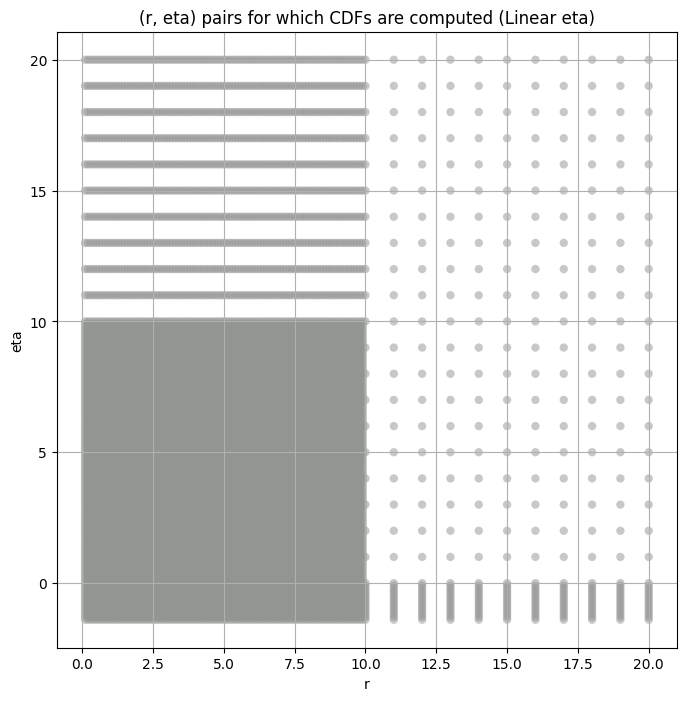

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:54<00:00, 1837.93it/s]


Layer 3


100%|██████████| 100000/100000 [01:15<00:00, 1326.00it/s]


Layer 4


100%|██████████| 100000/100000 [01:16<00:00, 1301.64it/s]


Layer 5


100%|██████████| 100000/100000 [01:06<00:00, 1505.45it/s]


Layer 6


100%|██████████| 100000/100000 [01:06<00:00, 1508.92it/s]


Layer 7


100%|██████████| 100000/100000 [01:06<00:00, 1494.87it/s]


Layer 8


100%|██████████| 100000/100000 [01:06<00:00, 1507.39it/s]


Layer 9


100%|██████████| 100000/100000 [01:07<00:00, 1472.49it/s]


obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005896e+07  2.753840e+07  3.271191e+07   0.729961    0.399370   
3      5.665110e+06  5.395799e+06  5.944192e+06   1.467750    1.230583   
4      1.100174e+06  1.039448e+06  1.163045e+06   2.750551    2.309108   
5      2.109796e+05  1.972241e+05  2.252361e+05   4.704504    4.043722   
6      4.082841e+04  3.771386e+04  4.411157e+04   7.281816    6.115109   
7      8.083446e+03  7.364765e+03  8.848112e+03  10.622059    8.626104   
8      1.791469e+03  1.614135e+03  1.980054e+03  13.650112   11.173287   
9      4.776892e+02  4.297687e+02  5.292324e+02  14.636528   11.965131   

       kurt_upper  total_samples  
layer                             
2        1.080867         2446.0  
3        1.719616         9784.0  
4        3.245366        39136.0  
5        5.443765       156544.0  
6        8.737838       626176.0  
7       13.357651      2504704.0  
8       16.722440     10018816.0  
9       17.953781     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      3.005896e+07   3.005896e+07    2.519029e+07    2.230202e+07   
3      5.665110e+06   5.665110e+06    5.290517e+06    5.022836e+06   
4      1.100174e+06   1.100174e+06    1.067176e+06    1.042356e+06   
5      2.109796e+05   2.109796e+05    2.072719e+05    2.043304e+05   
6      4.082841e+04   4.082841e+04    3.982941e+04    3.908744e+04   
7      8.083446e+03   8.083446e+03    7.818829e+03    7.633725e+03   
8      1.791469e+03   1.791469e+03    1.724851e+03    1.675920e+03   
9      4.776892e+02   4.776892e+02    4.591987e+02    4.456180e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        2.006981e+07     1.823265e+07     1.515751e+07     1.271778e+07   
3        4.794300e+06     4.593784e+06     4.247454e+06     3.955230e+06   
4        1.021168e+06     1.002539e+06     9.695196e+05     9.404084e+05   
5        2.016824e+05     1.992773e+05     1.949322e+05     1.910363e+05   
6        3.844080e+04     3.785405e+04     3.680544e+04     3.587533e+04   
7        7.474666e+03     7.331527e+03     7.079561e+03     6.858757e+03   
8        1.634064e+03     1.596733e+03     1.531272e+03     1.474512e+03   
9        4.339531e+02     4.235507e+02     4.053397e+02     3.896111e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         1.079548e+07     9.152717e+06     7.786938e+06     4.656862e+06  
3         3.702630e+06     3.481591e+06     3.284228e+06     2.787721e+06  
4         9.139301e+05     8.894421e+05     8.666529e+05     8.059100e+05  
5         1.874503e+05     1.840927e+05     1.809302e+05     1.724285e+05  
6         3.502844e+04     3.424924e+04     3.352437e+04     3.159654e+04  
7         6.660539e+03     6.479976e+03     6.313524e+03     5.878965e+03  
8         1.424060e+03     1.378466e+03     1.336804e+03     1.229561e+03  
9         3.756866e+02     3.631487e+02     3.517169e+02     3.223844e+02

####
Layer  2


100%|██████████| 12760/12760 [00:02<00:00, 4640.11it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.058427398769223315 30058960.0


100%|██████████| 12760/12760 [00:02<00:00, 5257.21it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.06013720905378794 25190288.0


100%|██████████| 12760/12760 [00:02<00:00, 5271.96it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.06824535193921133 22302020.0


100%|██████████| 12760/12760 [00:02<00:00, 5181.47it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.07986861546680413 20069806.0


100%|██████████| 12760/12760 [00:02<00:00, 5309.11it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.09045278724906902 18232646.0


100%|██████████| 12760/12760 [00:02<00:00, 5258.73it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.11006258544404157 15157508.0


100%|██████████| 12760/12760 [00:02<00:00, 5274.63it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.12956862686201565 12717784.0


100%|██████████| 12760/12760 [00:02<00:00, 5261.43it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.14738042045520405 10795475.0


100%|██████████| 12760/12760 [00:02<00:00, 5311.32it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.1641238672519102 9152717.0


100%|██████████| 12760/12760 [00:02<00:00, 5262.67it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.1797913874661583 7786938.0


100%|██████████| 12760/12760 [00:02<00:00, 5285.66it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.22940072411919477 4656862.0
Number of samples: 2446, Without approximation : 2446.0


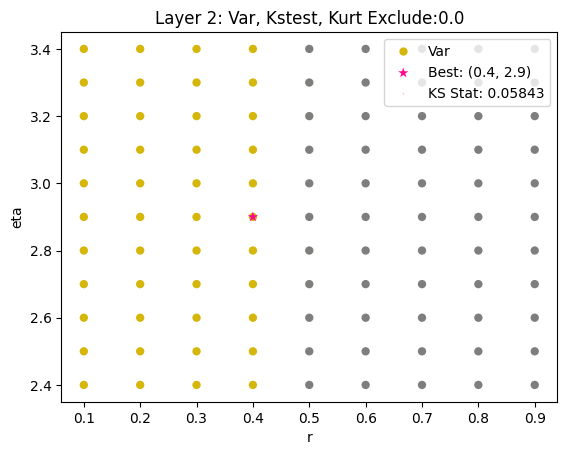

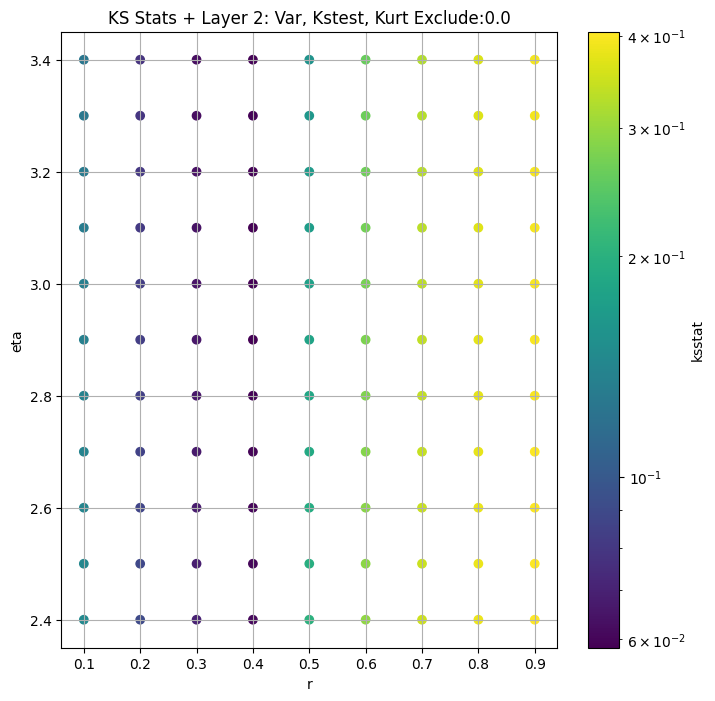

####
Layer  3


100%|██████████| 12760/12760 [00:07<00:00, 1717.58it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.04645605812537995 5665109.5


100%|██████████| 12760/12760 [00:09<00:00, 1397.93it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.04646325236283266 5290517.0


100%|██████████| 12760/12760 [00:07<00:00, 1722.18it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.04649666519095763 5022836.0


100%|██████████| 12760/12760 [00:07<00:00, 1709.50it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.046515387379734985 4794299.5


100%|██████████| 12760/12760 [00:07<00:00, 1711.76it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.04708631859003398 4593783.5


100%|██████████| 12760/12760 [00:07<00:00, 1714.37it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.048148457482421136 4247454.5


100%|██████████| 12760/12760 [00:07<00:00, 1711.67it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.05013524425767324 3955230.0


100%|██████████| 12760/12760 [00:07<00:00, 1713.23it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.05223250578167238 3702629.5


100%|██████████| 12760/12760 [00:07<00:00, 1709.86it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.05593254162483352 3481590.8


100%|██████████| 12760/12760 [00:07<00:00, 1707.18it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.061358038117521385 3284228.5


100%|██████████| 12760/12760 [00:07<00:00, 1705.35it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.0769957296726147 2787721.0
Number of samples: 9784, Without approximation : 9784.0


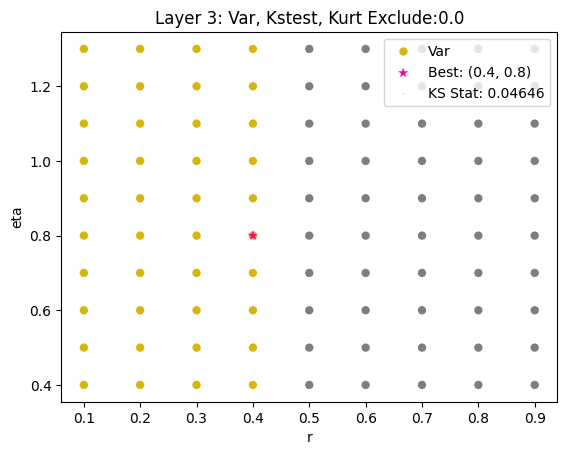

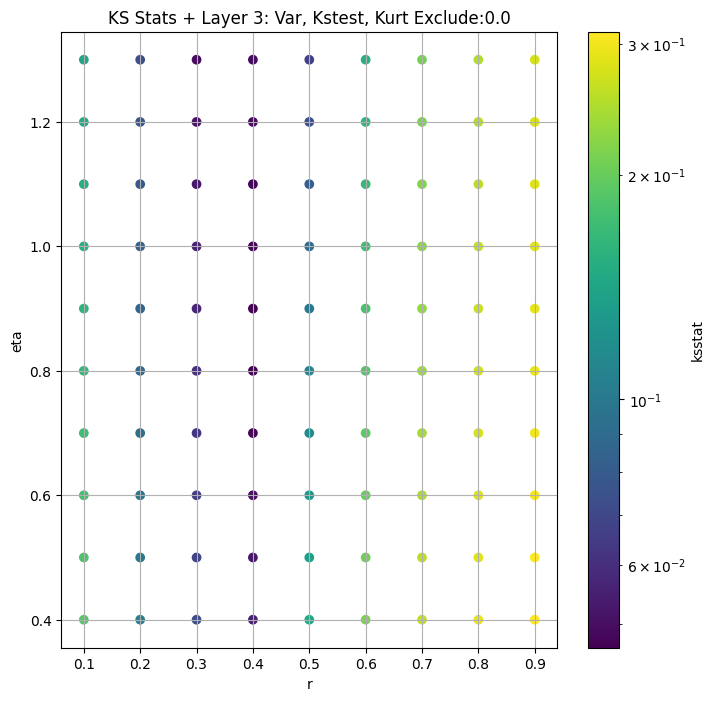

####
Layer  4


100%|██████████| 12760/12760 [00:27<00:00, 467.61it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.03249327209339564 1100174.5


100%|██████████| 12760/12760 [00:27<00:00, 469.44it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.032370791812400324 1067175.6


100%|██████████| 12760/12760 [00:27<00:00, 468.95it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.03197241966257397 1042355.6


100%|██████████| 12760/12760 [00:27<00:00, 468.94it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.03249327209339564 1021168.3


100%|██████████| 12760/12760 [00:27<00:00, 469.59it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.03249327209339564 1002539.1


100%|██████████| 12760/12760 [00:27<00:00, 470.18it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.03249327209339564 969519.56


100%|██████████| 12760/12760 [00:28<00:00, 453.26it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.03249327209339564 940408.44


100%|██████████| 12760/12760 [00:27<00:00, 470.56it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.033742554225222654 913930.1


100%|██████████| 12760/12760 [00:27<00:00, 469.52it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.034070260681902 889442.06


100%|██████████| 12760/12760 [00:27<00:00, 469.91it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.03426270550778815 866652.9


100%|██████████| 12760/12760 [00:27<00:00, 469.94it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.03679064437294738 805910.0
Number of samples: 39136, Without approximation : 39136.0


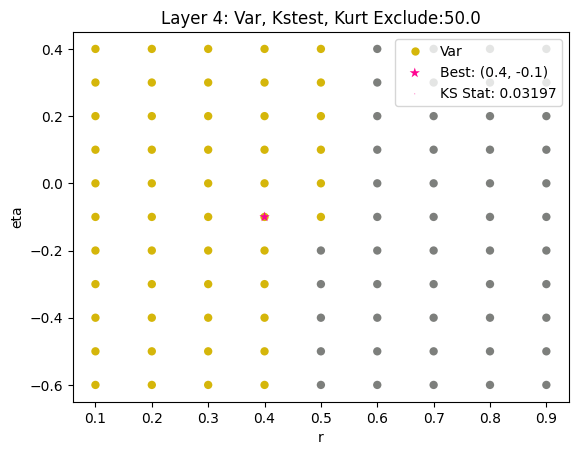

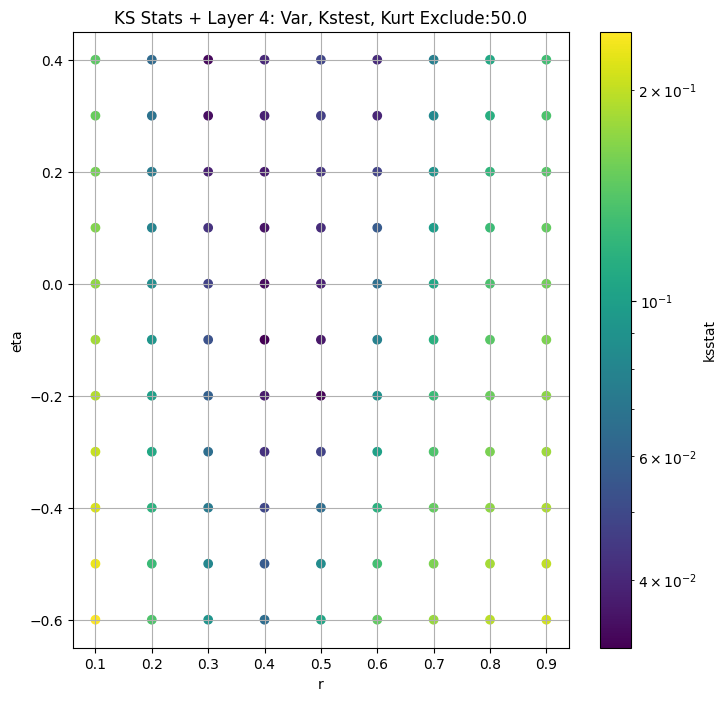

####
Layer  5


100%|██████████| 12760/12760 [01:07<00:00, 187.68it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.025303117427406263 210979.58


100%|██████████| 12760/12760 [01:07<00:00, 187.96it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.02529482866549776 207271.92


100%|██████████| 12760/12760 [01:07<00:00, 187.81it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.025288093919844212 204330.44


100%|██████████| 12760/12760 [01:08<00:00, 187.61it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.02528190618401266 201682.36


100%|██████████| 12760/12760 [01:08<00:00, 187.62it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.025276180431015594 199277.28


100%|██████████| 12760/12760 [01:07<00:00, 187.83it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.02539570225426474 194932.25


100%|██████████| 12760/12760 [01:07<00:00, 188.09it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.02539570225426474 191036.27


100%|██████████| 12760/12760 [01:09<00:00, 184.52it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.02539570225426474 187450.3


100%|██████████| 12760/12760 [01:07<00:00, 188.00it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.025389424026868834 184092.7


100%|██████████| 12760/12760 [01:09<00:00, 183.71it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.02537815198746196 180930.16


100%|██████████| 12760/12760 [01:07<00:00, 187.73it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.025346346219712323 172428.53
Number of samples: 100000, Without approximation : 156544.0


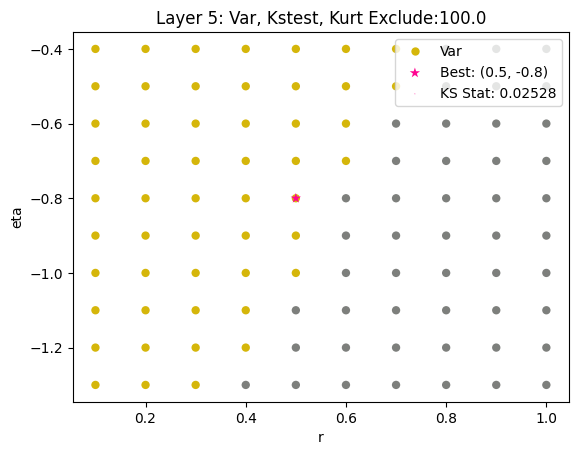

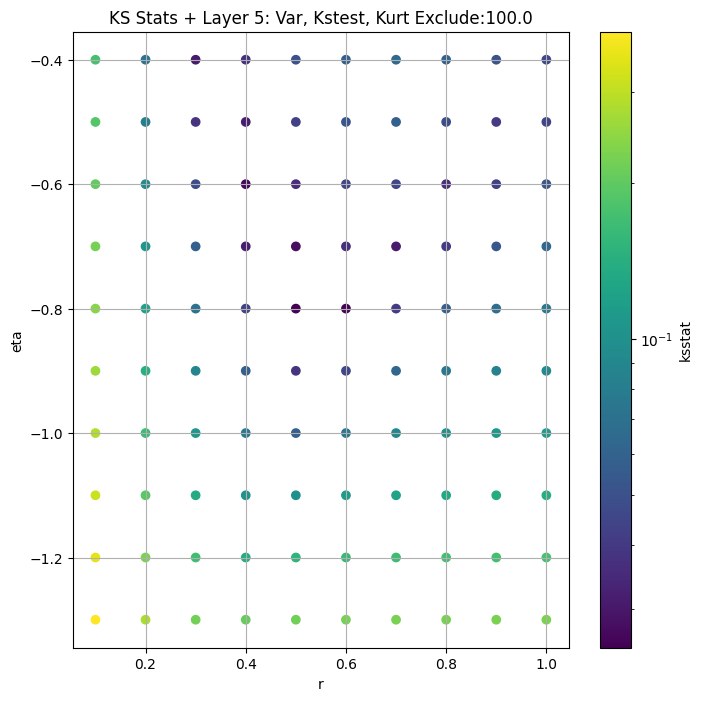

####
Layer  6


100%|██████████| 12760/12760 [01:08<00:00, 187.36it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.027712398516452963 40828.41


100%|██████████| 12760/12760 [01:07<00:00, 187.95it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.027651897296262162 39829.406


100%|██████████| 12760/12760 [01:07<00:00, 188.20it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.027665415654975822 39087.44


100%|██████████| 12760/12760 [01:07<00:00, 188.07it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.027903268552569416 38440.8


100%|██████████| 12760/12760 [01:07<00:00, 187.86it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.02812385401013595 37854.047


100%|██████████| 12760/12760 [01:07<00:00, 187.76it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.028531154713079876 36805.438


100%|██████████| 12760/12760 [01:07<00:00, 188.17it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.02890952134370317 35875.332


100%|██████████| 12760/12760 [01:07<00:00, 188.07it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.027979102008809542 35028.438


100%|██████████| 12760/12760 [01:07<00:00, 187.82it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.02791092172946652 34249.242


100%|██████████| 12760/12760 [01:07<00:00, 187.87it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.02784544083835766 33524.37


100%|██████████| 12760/12760 [01:09<00:00, 183.09it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.02768041482091277 31596.54
Number of samples: 100000, Without approximation : 626176.0


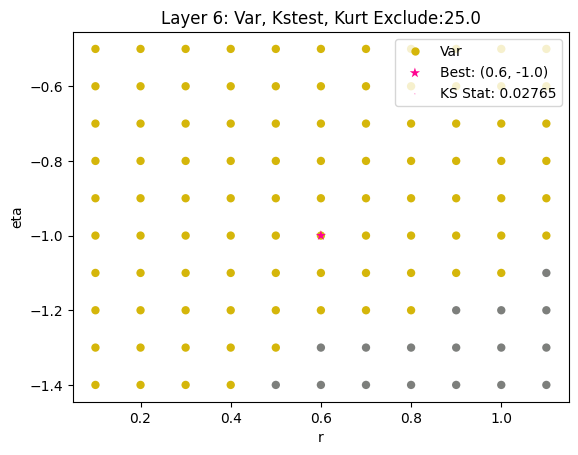

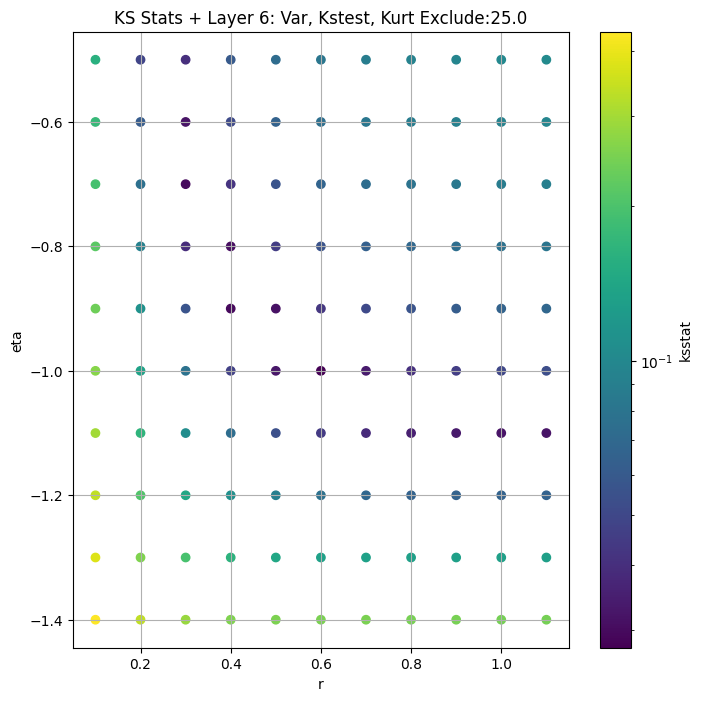

####
Layer  7


100%|██████████| 12760/12760 [01:09<00:00, 182.45it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.03464999999995111 8083.446


100%|██████████| 12760/12760 [01:07<00:00, 187.89it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.03464999999995211 7818.829


100%|██████████| 12760/12760 [01:07<00:00, 188.01it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.0346499999999515 7633.7246


100%|██████████| 12760/12760 [01:07<00:00, 187.74it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.03464999999995105 7474.6655


100%|██████████| 12760/12760 [01:08<00:00, 187.26it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.034649999999951775 7331.527


100%|██████████| 12760/12760 [01:14<00:00, 171.42it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.034649999999951 7079.5605


100%|██████████| 12760/12760 [01:10<00:00, 181.97it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.03464999999995083 6858.757


100%|██████████| 12760/12760 [04:33<00:00, 46.62it/s] 


Finding Minimum after computing 12760 CDFs
7 250 0.0346499999999505 6660.5386


100%|██████████| 12760/12760 [08:04<00:00, 26.36it/s] 


Finding Minimum after computing 12760 CDFs
7 300 0.03464999999995061 6479.9756


100%|██████████| 12760/12760 [02:33<00:00, 83.03it/s] 


Finding Minimum after computing 12760 CDFs
7 350 0.03464999999995039 6313.524


100%|██████████| 12760/12760 [00:45<00:00, 280.90it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.034649999999950165 5878.965
Number of samples: 100000, Without approximation : 2504704.0


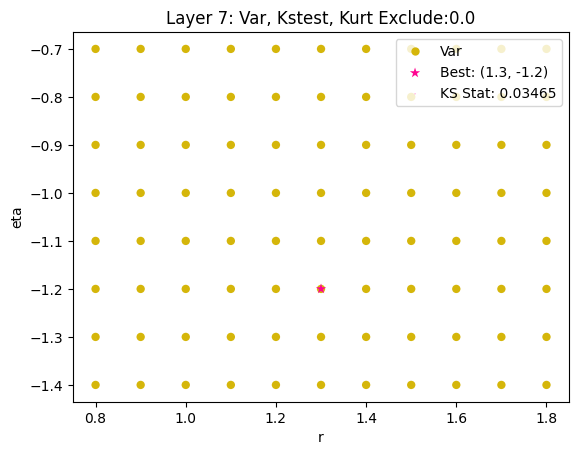

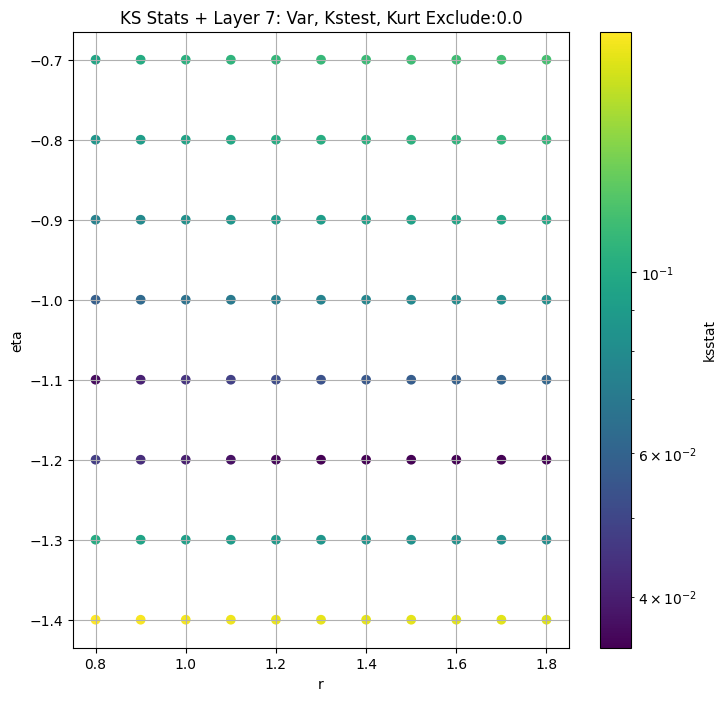

####
Layer  8


100%|██████████| 12760/12760 [00:44<00:00, 289.04it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.03265999999993907 1791.4688


100%|██████████| 12760/12760 [00:43<00:00, 295.04it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.03265999999993796 1724.8514


100%|██████████| 12760/12760 [00:42<00:00, 300.01it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.03265999999993696 1675.92


100%|██████████| 12760/12760 [00:42<00:00, 301.10it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.03265999999993624 1634.0641


100%|██████████| 12760/12760 [00:42<00:00, 301.92it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.03265999999993546 1596.7333


100%|██████████| 12760/12760 [00:42<00:00, 300.84it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.032659999999934186 1531.2716


100%|██████████| 12760/12760 [00:42<00:00, 299.40it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.032659999999932854 1474.5118


100%|██████████| 12760/12760 [00:42<00:00, 300.48it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.032659999999941625 1424.0604


100%|██████████| 12760/12760 [00:42<00:00, 299.91it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.03265999999994079 1378.4664


100%|██████████| 12760/12760 [00:42<00:00, 300.55it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.03265999999993985 1336.804


100%|██████████| 12760/12760 [00:42<00:00, 300.16it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.032659999999937295 1229.5612
Number of samples: 100000, Without approximation : 10018816.0


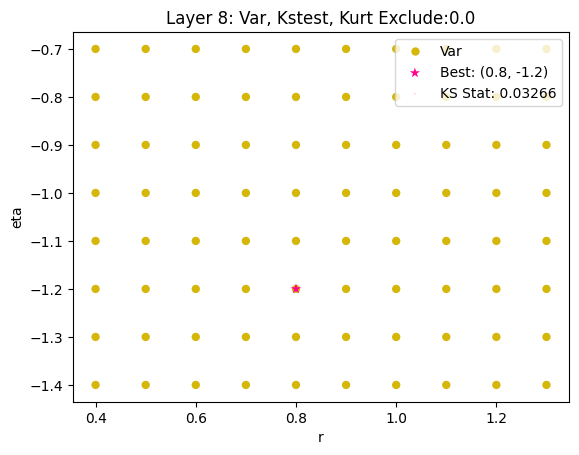

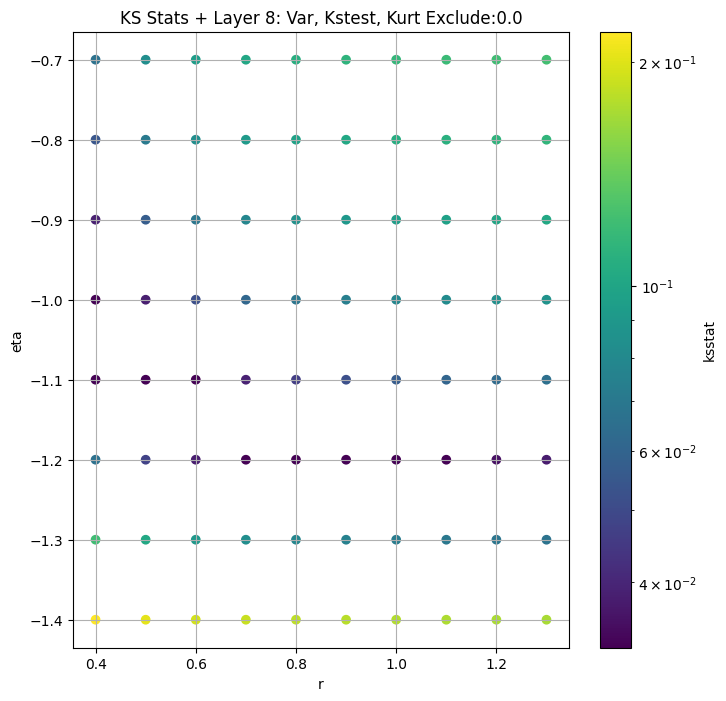

####
Layer  9


100%|██████████| 12760/12760 [00:42<00:00, 300.35it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.05322999999822725 477.68924


100%|██████████| 12760/12760 [00:42<00:00, 298.35it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.05322999999821049 459.19873


100%|██████████| 12760/12760 [00:42<00:00, 297.44it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.0532299999982041 445.618


100%|██████████| 12760/12760 [00:43<00:00, 292.32it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.05322999999819872 433.9531


100%|██████████| 12760/12760 [00:42<00:00, 297.14it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.05322999999819372 423.5507


100%|██████████| 12760/12760 [00:44<00:00, 285.86it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.05322999999817868 405.3397


100%|██████████| 12760/12760 [00:42<00:00, 297.71it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.05322999999993122 389.61108


100%|██████████| 12760/12760 [00:43<00:00, 292.50it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.05322999999992983 375.68658


100%|██████████| 12760/12760 [00:43<00:00, 291.94it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.05322999999992861 363.14868


100%|██████████| 12760/12760 [00:43<00:00, 291.11it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.05322999999992756 351.71686


100%|██████████| 12760/12760 [00:46<00:00, 275.52it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.05322999999992428 322.38437
Number of samples: 100000, Without approximation : 40075264.0


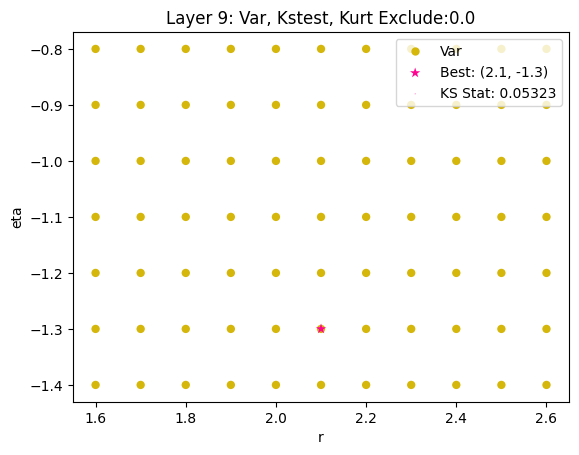

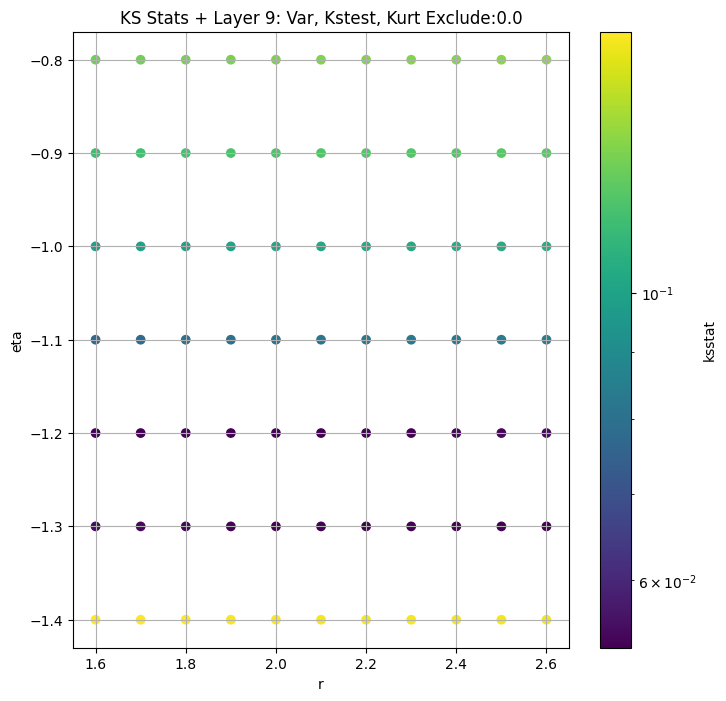

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005896e+07  2.753840e+07  3.271191e+07   0.729961    0.399370   
3      5.665110e+06  5.395799e+06  5.944192e+06   1.467750    1.230583   
4      1.100174e+06  1.039448e+06  1.163045e+06   2.750551    2.309108   
5      2.109796e+05  1.972241e+05  2.252361e+05   4.704504    4.043722   
6      4.082841e+04  3.771386e+04  4.411157e+04   7.281816    6.115109   
7      8.083446e+03  7.364765e+03  8.848112e+03  10.622059    8.626104   
8      1.791469e+03  1.614135e+03  1.980054e+03  13.650112   11.173287   
9      4.776892e+02  4.297687e+02  5.292324e+02  14.636528   11.965131   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080867         2446.0             0.058427        0.4          2.9   
3        1.719616         9784.0             0.046456        0.4          0.8   
4        3.245366        39136.0             0.031972        0.4         -0.1   
5        5.443765       156544.0             0.025276        0.5         -0.8   
6        8.737838       626176.0             0.027652        0.6         -1.0   
7       13.357651      2504704.0             0.034650        1.3         -1.2   
8       16.722440     10018816.0             0.032660        0.8         -1.2   
9       17.953781     40075264.0             0.053230        2.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       63768.062808                     0.0        3.005896e+07   
3       53282.642395                     0.0        5.665110e+06   
4       28867.613149                    50.0        1.042356e+06   
5       59308.714658                   100.0        1.992773e+05   
6       33820.470350                    25.0        3.982941e+04   
7       31895.998733                     0.0        8.083446e+03   
8        4736.431150                     0.0        1.791469e+03   
9        3067.817152                     0.0        4.776892e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/792 [00:00<?, ?it/s]

100%|██████████| 792/792 [00:00<00:00, 4883.68it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.1049105377516848, var: 18232646.0


100%|██████████| 792/792 [00:00<00:00, 8897.57it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.09522399422452466, var: 20069806.0


100%|██████████| 792/792 [00:00<00:00, 8939.16it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.0844603405764397, var: 22302020.0


100%|██████████| 792/792 [00:00<00:00, 8838.31it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.0713973904070947, var: 25190288.0


100%|██████████| 792/792 [00:00<00:00, 8815.02it/s]


Finding Minimum after computing 792 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.058418504020038675, var: 30058960.0
Number of samples: 2446, Without approximation : 2446.0


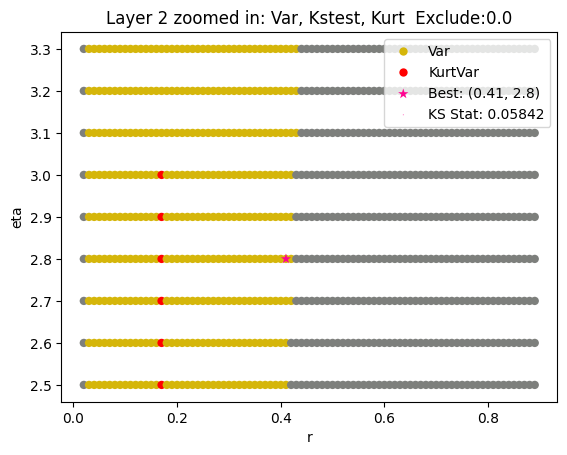

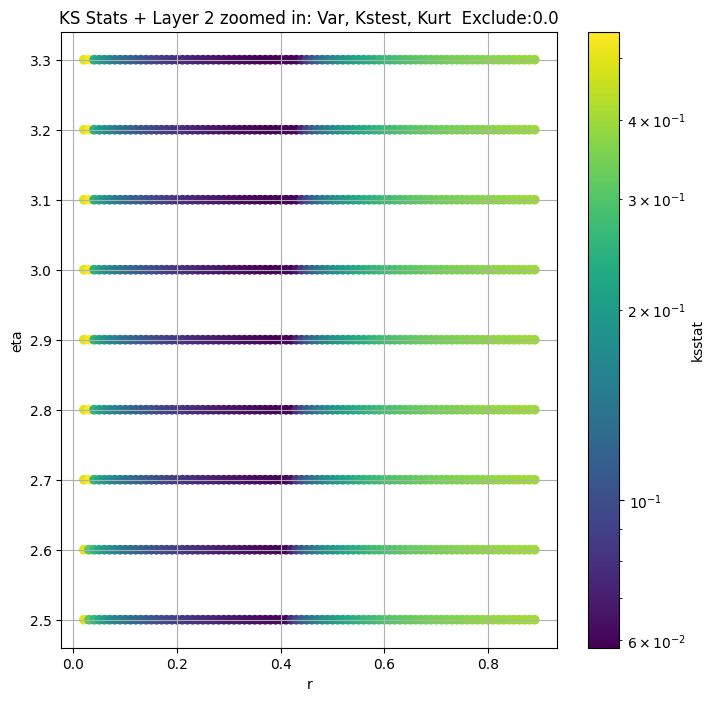

Layer 3


100%|██████████| 792/792 [00:00<00:00, 1940.25it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.0478725314749171, var: 4593783.5


100%|██████████| 792/792 [00:00<00:00, 2739.89it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.04650113603208628, var: 4794299.5


100%|██████████| 792/792 [00:00<00:00, 2796.63it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.04649666519095763, var: 5022836.0


100%|██████████| 792/792 [00:00<00:00, 2794.76it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.04646243374347864, var: 5290517.0


100%|██████████| 792/792 [00:00<00:00, 2784.22it/s]


Finding Minimum after computing 792 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.04644529154098781, var: 5665109.5
Number of samples: 9784, Without approximation : 9784.0


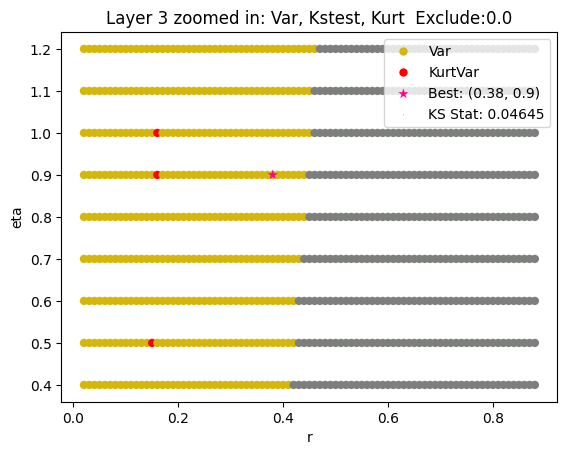

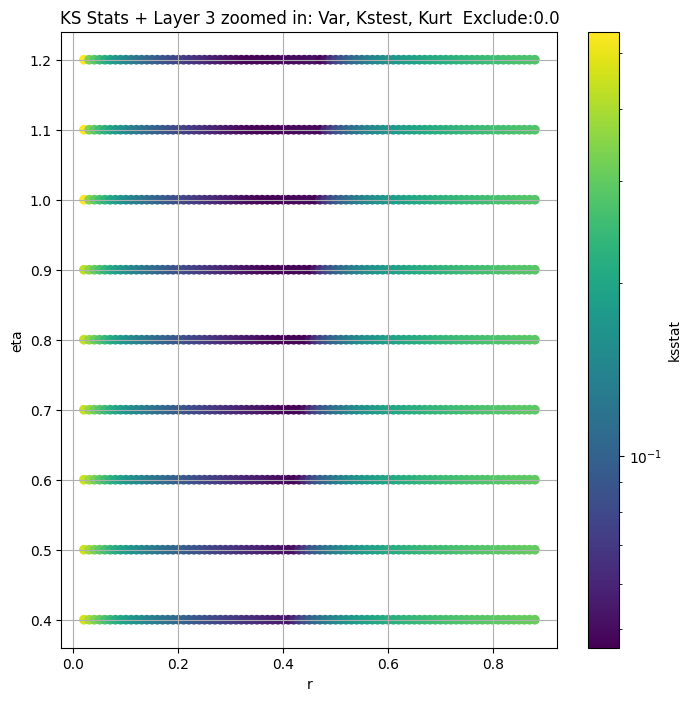

Layer 4


100%|██████████| 1224/1224 [00:01<00:00, 697.01it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 100 = 150, ksstat: 0.03202750140135391, var: 969519.5625


100%|██████████| 1224/1224 [00:01<00:00, 754.04it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 75 = 125, ksstat: 0.032060753585482216, var: 985405.5625


100%|██████████| 1224/1224 [00:01<00:00, 754.94it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 50 = 100, ksstat: 0.032073409185461754, var: 1002539.125


100%|██████████| 1224/1224 [00:01<00:00, 753.14it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 25 = 75, ksstat: 0.03205461842462387, var: 1021168.3125


100%|██████████| 1224/1224 [00:01<00:00, 749.96it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + 0 = 50, ksstat: 0.03169961707127633, var: 1042355.625


100%|██████████| 1224/1224 [00:01<00:00, 755.41it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + -25 = 25, ksstat: 0.03140883173392778, var: 1067175.625


100%|██████████| 1224/1224 [00:01<00:00, 756.42it/s]


Finding Minimum after computing 1224 CDFs
layer 4, 50.0 + -50 = 0, ksstat: 0.031444131173801126, var: 1100174.5
Number of samples: 39136, Without approximation : 39136.0


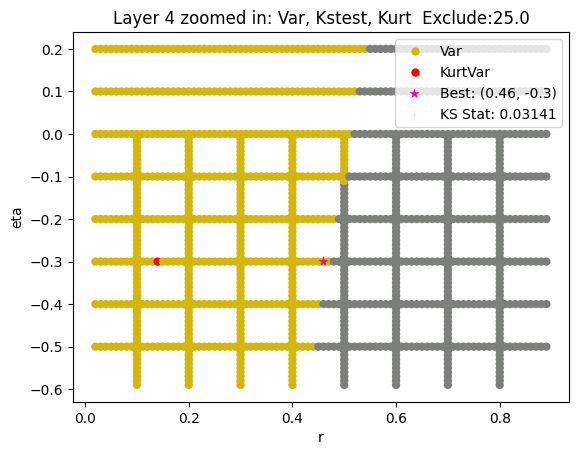

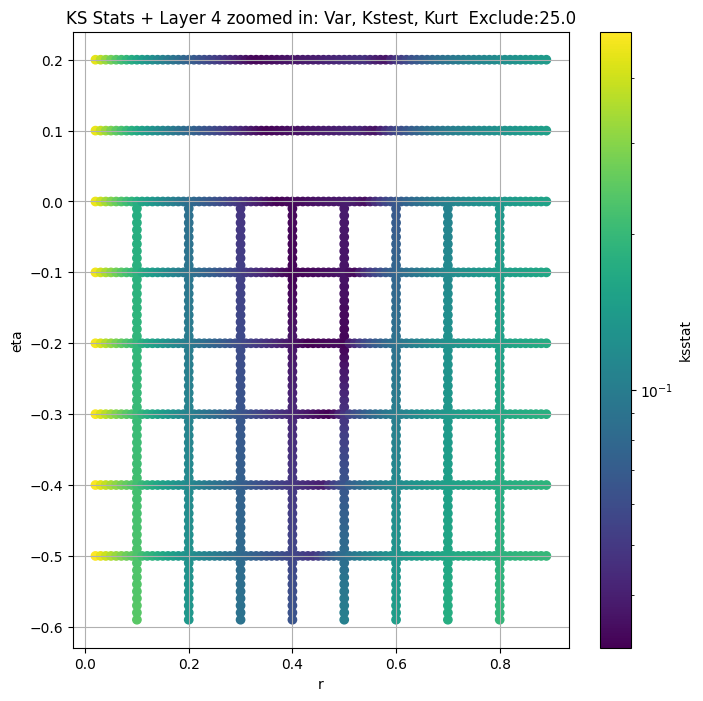

Layer 5


100%|██████████| 1692/1692 [00:05<00:00, 293.11it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 100 = 200, ksstat: 0.025281565161590303, var: 191036.265625


100%|██████████| 1692/1692 [00:05<00:00, 299.17it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 75 = 175, ksstat: 0.02528619481666433, var: 192936.171875


100%|██████████| 1692/1692 [00:05<00:00, 295.77it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 50 = 150, ksstat: 0.02527514207820364, var: 194932.25


100%|██████████| 1692/1692 [00:07<00:00, 238.66it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 25 = 125, ksstat: 0.025280197889842593, var: 197037.296875


100%|██████████| 1692/1692 [00:05<00:00, 289.98it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + 0 = 100, ksstat: 0.025276180431015594, var: 199277.28125


100%|██████████| 1692/1692 [00:05<00:00, 290.26it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -25 = 75, ksstat: 0.02528190618401266, var: 201682.359375


100%|██████████| 1692/1692 [00:05<00:00, 300.03it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -50 = 50, ksstat: 0.025258353881032924, var: 204330.4375


100%|██████████| 1692/1692 [00:05<00:00, 300.45it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -75 = 25, ksstat: 0.025233686642279207, var: 207271.921875


100%|██████████| 1692/1692 [00:05<00:00, 302.31it/s]


Finding Minimum after computing 1692 CDFs
layer 5, 100.0 + -100 = 0, ksstat: 0.02520892081857401, var: 210979.578125
Number of samples: 100000, Without approximation : 156544.0


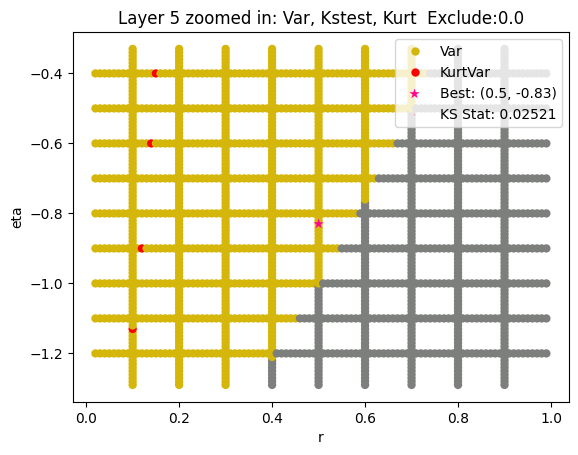

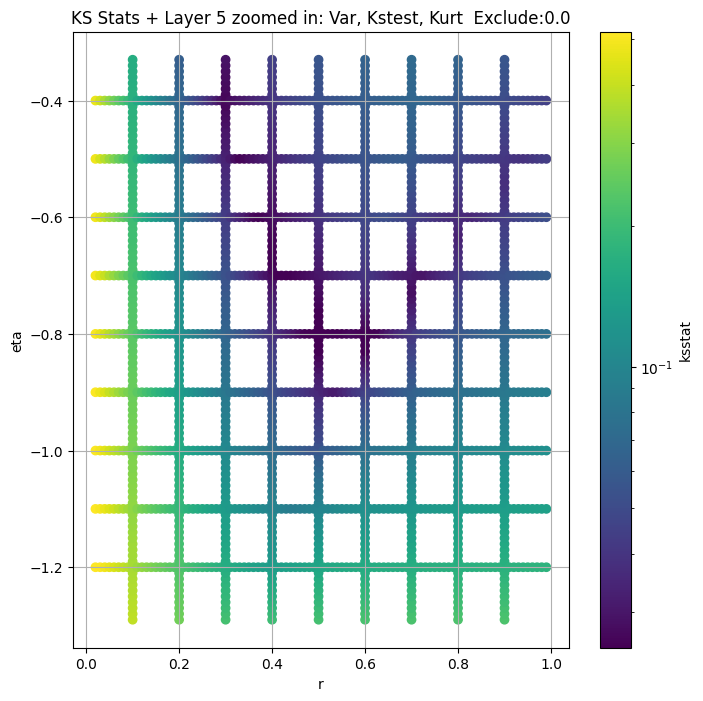

Layer 6


100%|██████████| 1665/1665 [00:05<00:00, 300.03it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.027457002276904452, var: 37312.02734375


100%|██████████| 1665/1665 [00:05<00:00, 299.33it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.027522285428595528, var: 37854.046875


100%|██████████| 1665/1665 [00:05<00:00, 297.96it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.02764572161910267, var: 38440.80078125


100%|██████████| 1665/1665 [00:05<00:00, 301.93it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.027665415654975822, var: 39087.44140625


100%|██████████| 1665/1665 [00:05<00:00, 296.52it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.027651897296262162, var: 39829.40625


100%|██████████| 1665/1665 [00:05<00:00, 301.46it/s]


Finding Minimum after computing 1665 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.027652199872720884, var: 40828.41015625
Number of samples: 100000, Without approximation : 626176.0


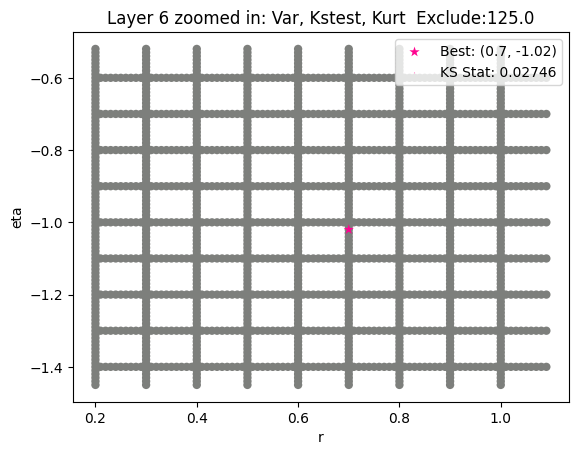

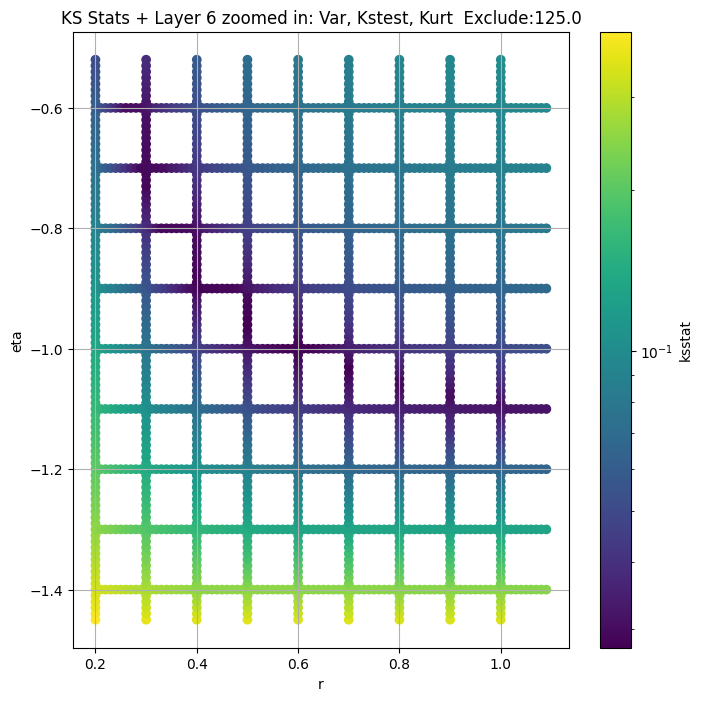

Layer 7


100%|██████████| 1305/1305 [00:04<00:00, 298.24it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.0346499999999505, var: 7331.52685546875


100%|██████████| 1305/1305 [00:04<00:00, 299.66it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.0346499999999505, var: 7474.66552734375


100%|██████████| 1305/1305 [00:04<00:00, 298.47it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.034649999999950665, var: 7633.724609375


100%|██████████| 1305/1305 [00:04<00:00, 299.90it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.03464999999995072, var: 7818.8291015625


100%|██████████| 1305/1305 [00:04<00:00, 301.61it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.034649999999950776, var: 8083.44580078125
Number of samples: 100000, Without approximation : 2504704.0


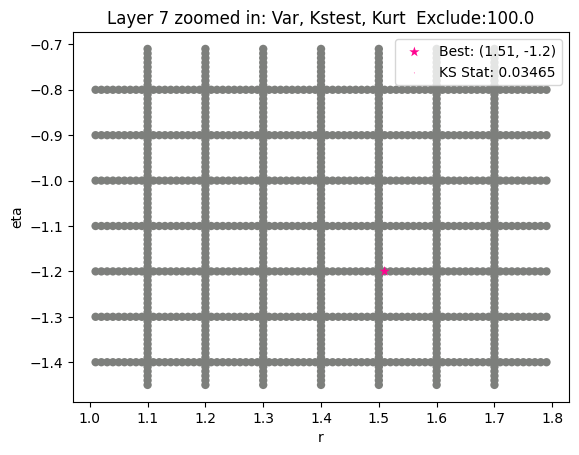

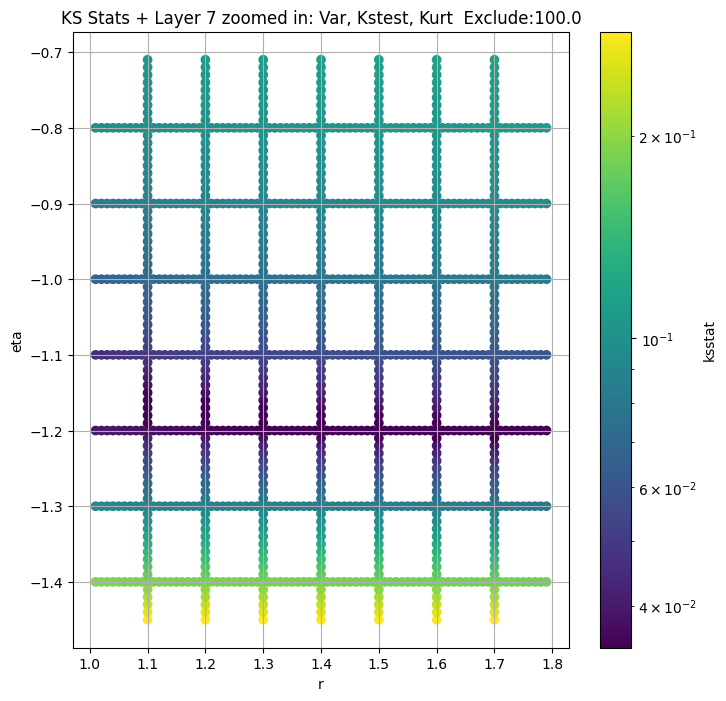

Layer 8


100%|██████████| 1305/1305 [00:04<00:00, 297.18it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.03265999999993241, var: 1596.7332763671875


100%|██████████| 1305/1305 [00:04<00:00, 299.57it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.032659999999932576, var: 1634.0640869140625


100%|██████████| 1305/1305 [00:04<00:00, 299.15it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.03265999999981972, var: 1675.9200439453125


100%|██████████| 1305/1305 [00:04<00:00, 301.05it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.032659999999822276, var: 1724.8514404296875


100%|██████████| 1305/1305 [00:04<00:00, 300.82it/s]


Finding Minimum after computing 1305 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.03265999999981967, var: 1791.46875
Number of samples: 100000, Without approximation : 10018816.0


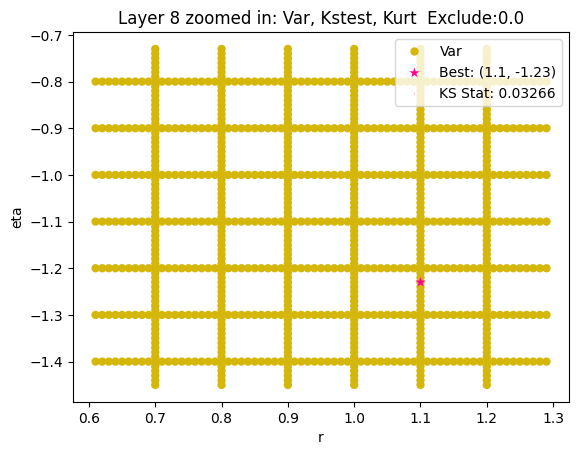

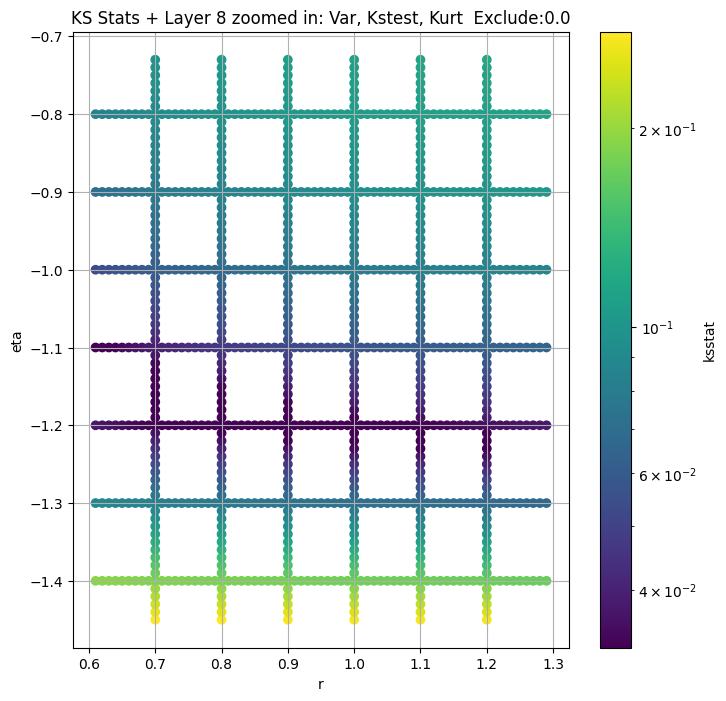

Layer 9


100%|██████████| 506/506 [00:01<00:00, 297.93it/s]


Finding Minimum after computing 506 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.05322999999934469, var: 423.5506896972656


100%|██████████| 506/506 [00:01<00:00, 301.72it/s]


Finding Minimum after computing 506 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.05322999999935257, var: 433.9530944824219


100%|██████████| 506/506 [00:01<00:00, 299.37it/s]


Finding Minimum after computing 506 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.05322999999936118, var: 445.6180114746094


100%|██████████| 506/506 [00:01<00:00, 300.97it/s]


Finding Minimum after computing 506 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.05322999999821049, var: 459.19873046875


100%|██████████| 506/506 [00:01<00:00, 301.64it/s]


Finding Minimum after computing 506 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.05322999999821476, var: 477.6892395019531
Number of samples: 100000, Without approximation : 40075264.0


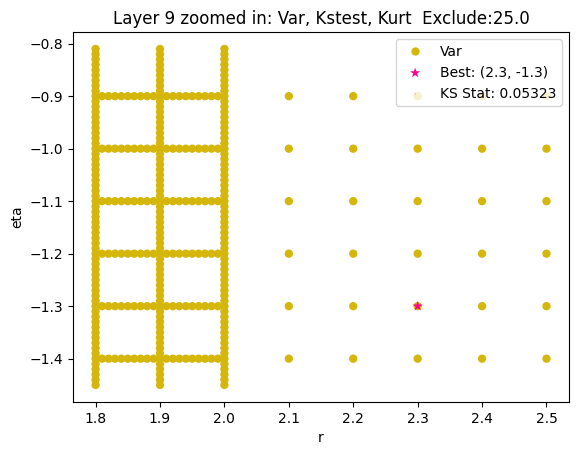

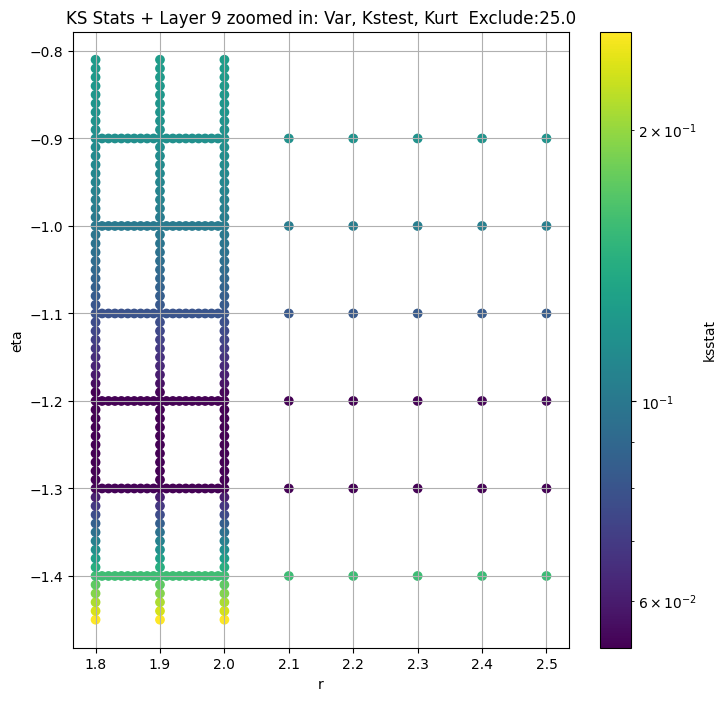

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005896e+07  2.753840e+07  3.271191e+07   0.729961    0.399370   
3      5.665110e+06  5.395799e+06  5.944192e+06   1.467750    1.230583   
4      1.100174e+06  1.039448e+06  1.163045e+06   2.750551    2.309108   
5      2.109796e+05  1.972241e+05  2.252361e+05   4.704504    4.043722   
6      4.082841e+04  3.771386e+04  4.411157e+04   7.281816    6.115109   
7      8.083446e+03  7.364765e+03  8.848112e+03  10.622059    8.626104   
8      1.791469e+03  1.614135e+03  1.980054e+03  13.650112   11.173287   
9      4.776892e+02  4.297687e+02  5.292324e+02  14.636528   11.965131   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080867         2446.0             0.058427        0.4          2.9   
3        1.719616         9784.0             0.046456        0.4          0.8   
4        3.245366        39136.0             0.031972        0.4         -0.1   
5        5.443765       156544.0             0.025276        0.5         -0.8   
6        8.737838       626176.0             0.027652        0.6         -1.0   
7       13.357651      2504704.0             0.034650        1.3         -1.2   
8       16.722440     10018816.0             0.032660        0.8         -1.2   
9       17.953781     40075264.0             0.053230        2.1         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       63768.062808                     0.0        3.005896e+07   
3       53282.642395                     0.0        5.665110e+06   
4       28867.613149                    50.0        1.067176e+06   
5       59308.714658                   100.0        2.109796e+05   
6       33820.470350                    25.0        3.731203e+04   
7       31895.998733                     0.0        7.331527e+03   
8        4736.431150                     0.0        1.791469e+03   
9        3067.817152                     0.0        4.591987e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.058419    0.41      2.80   
3                     0.013713          0.046445    0.38      0.90   
4                     0.006861          0.031409    0.46     -0.30   
5                     0.003431          0.025209    0.50     -0.83   
6                     0.001716          0.027457    0.70     -1.02   
7                     0.000858          0.034650    1.51     -1.20   
8                     0.000429          0.032660    1.10     -1.23   
9                     0.000215          0.053230    2.30     -1.30   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      83168.052034                  0.0          513  
3      32626.350621                  0.0          868  
4      88303.427171                 25.0         1834  
5      67285.233488                  0.0         2751  
6      46780.730632                125.0         2446  
7      30750.380032                100.0         1546  
8       7108.964953                  0.0         1738  
9       2971.402850                 25.0          648

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

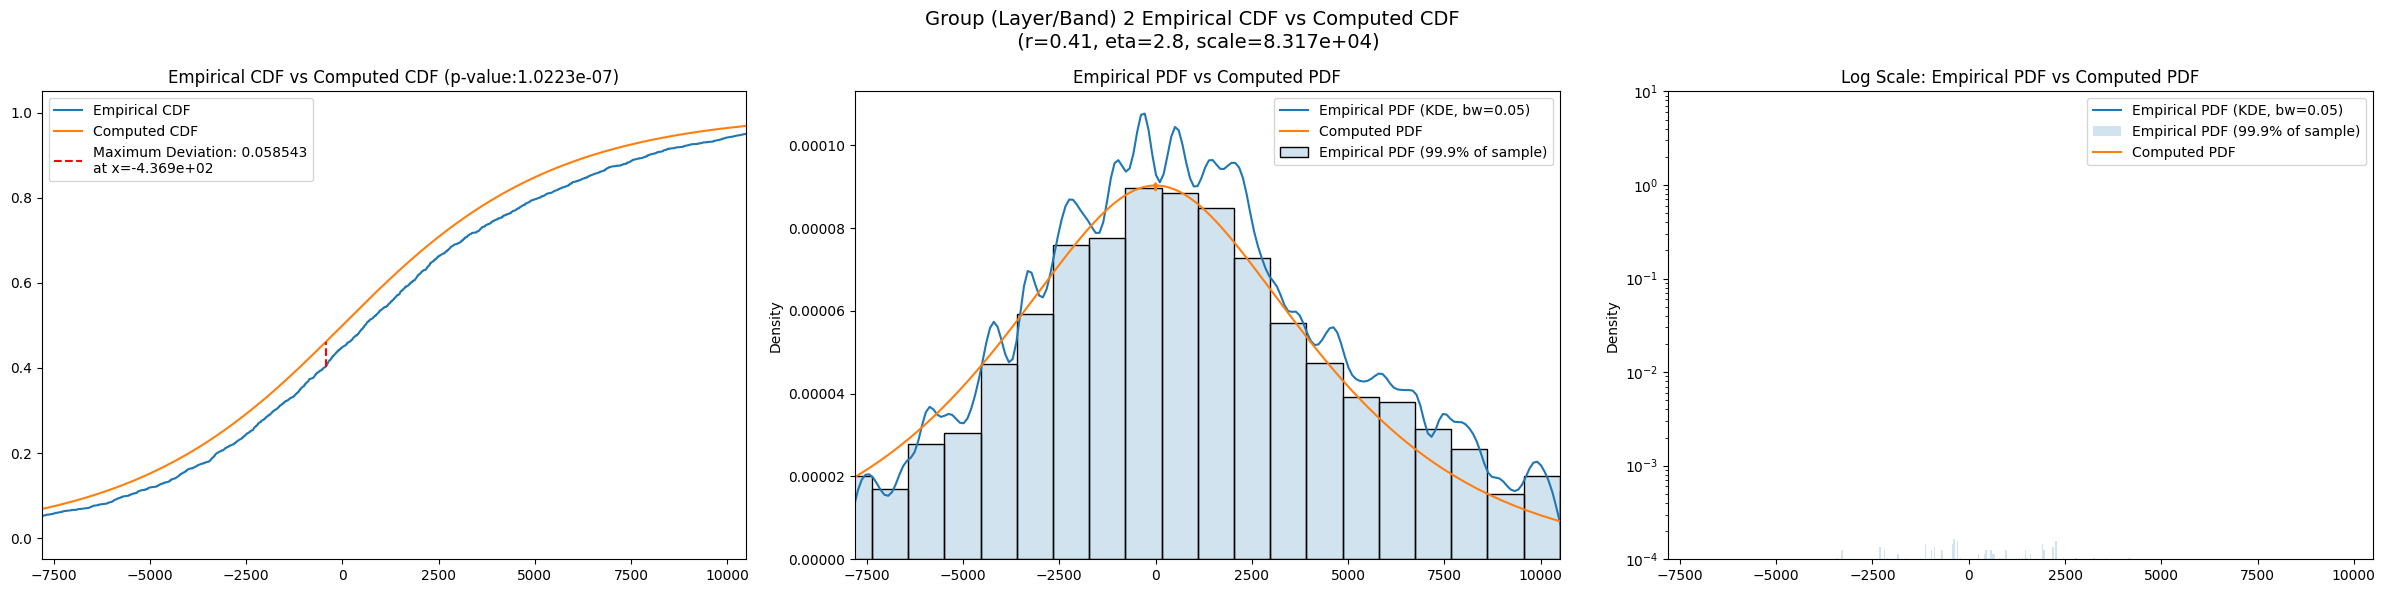

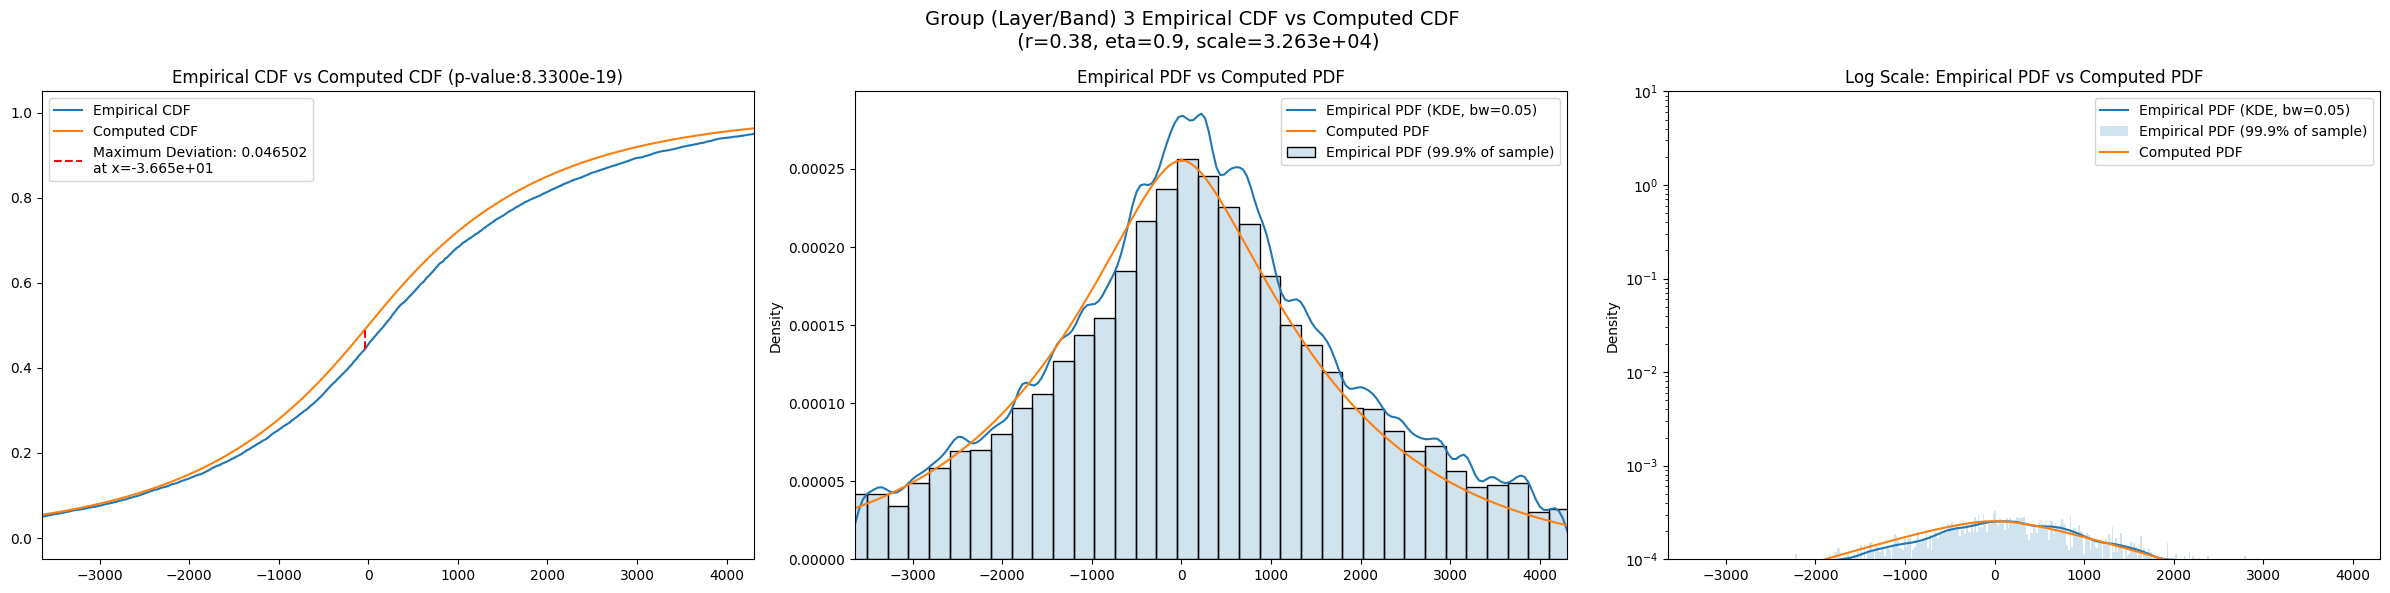

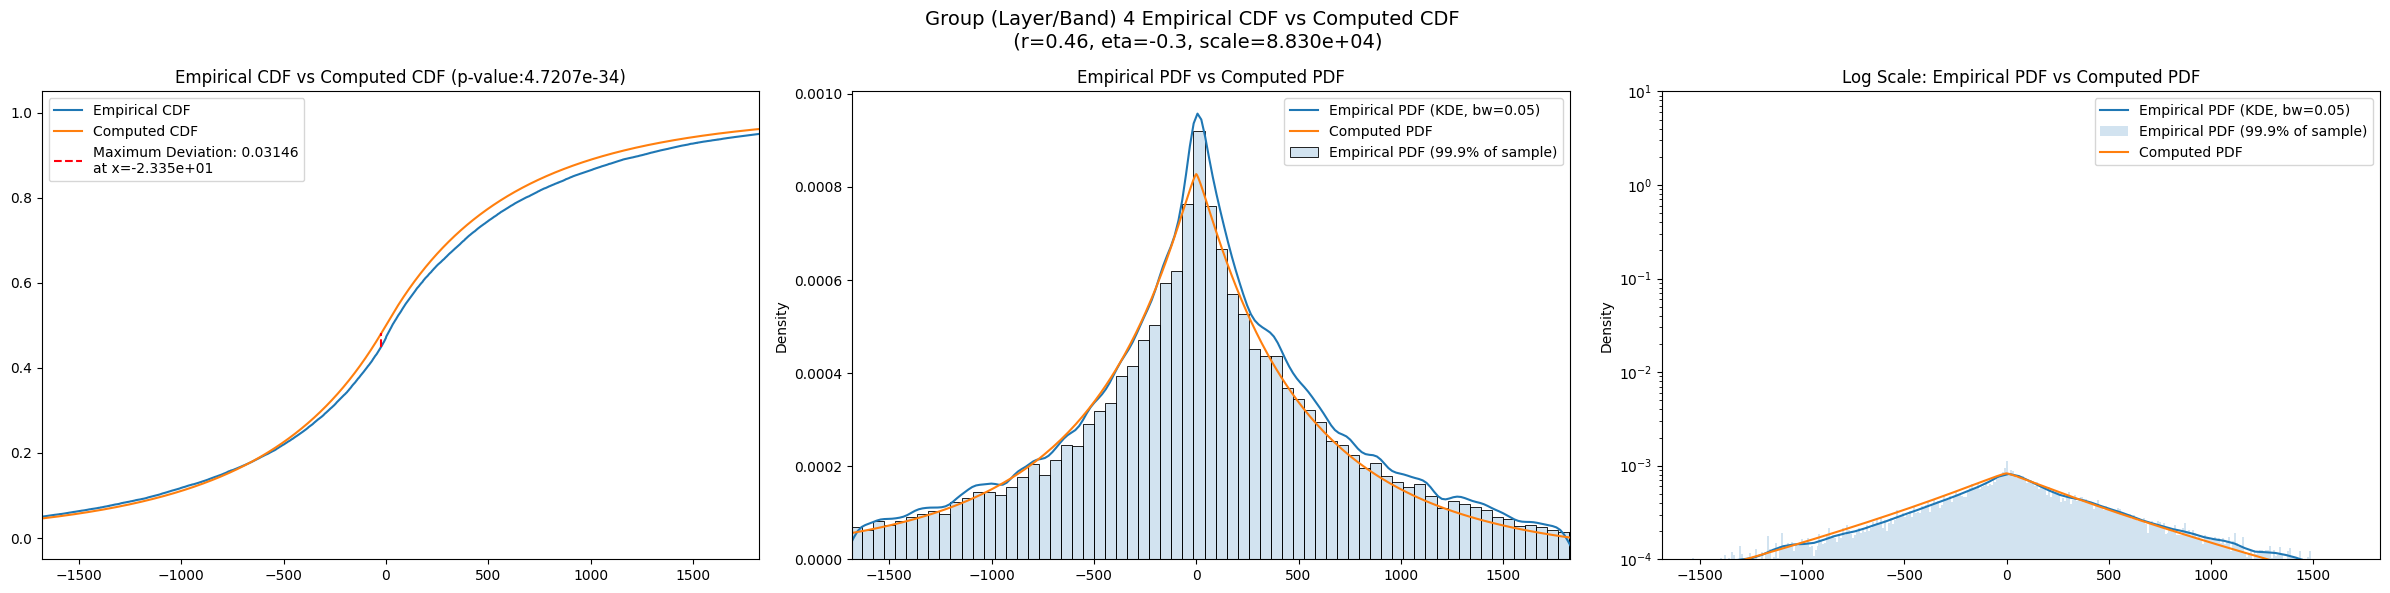

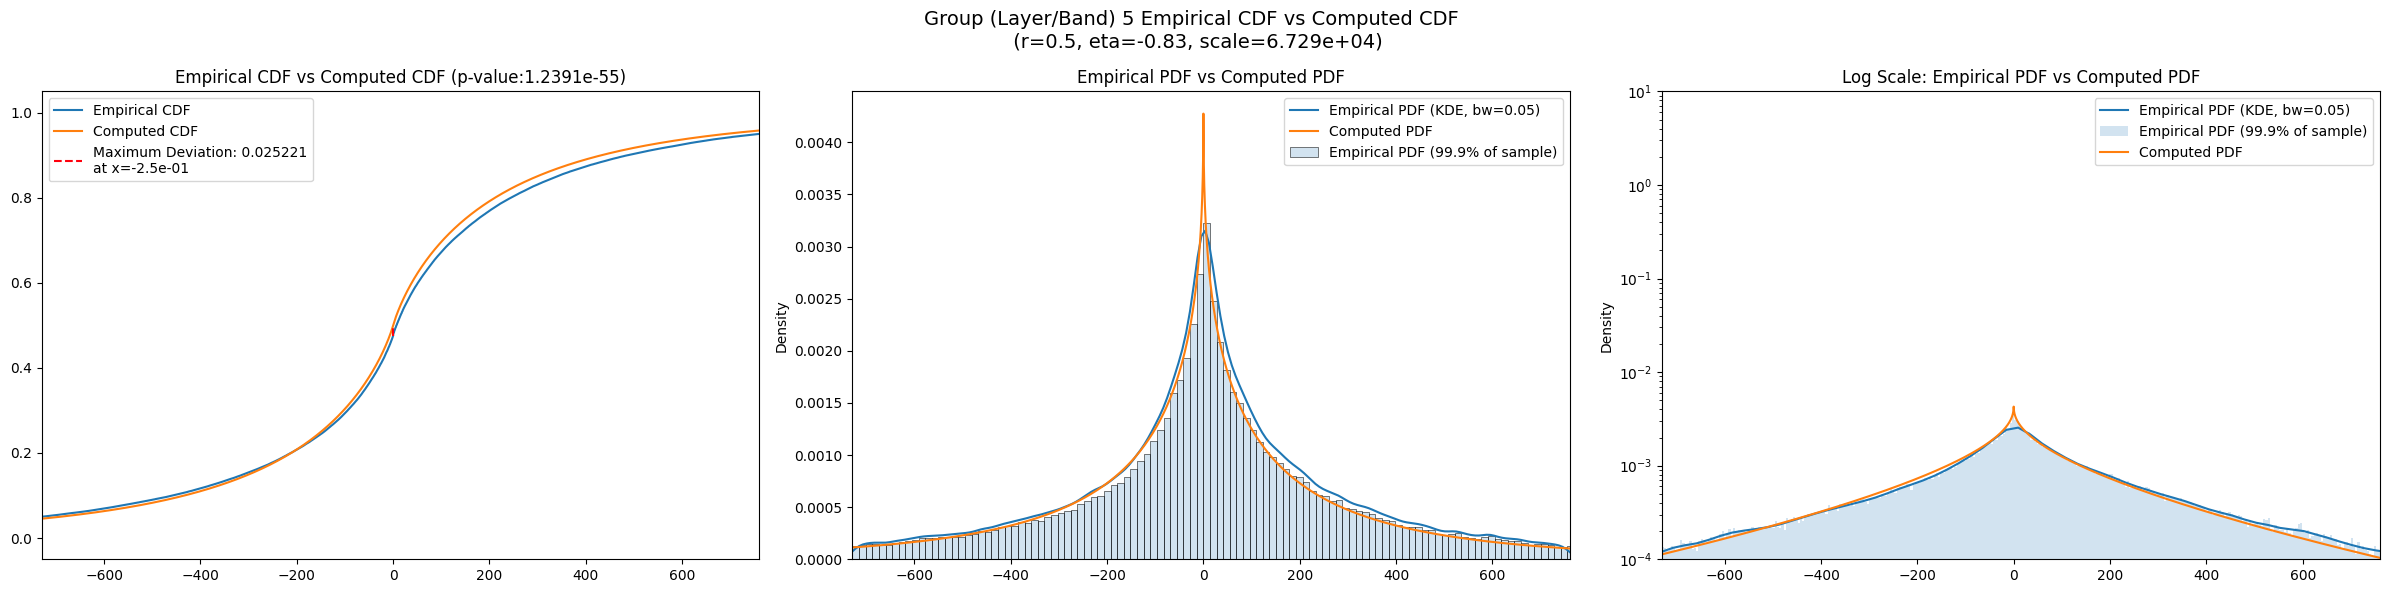

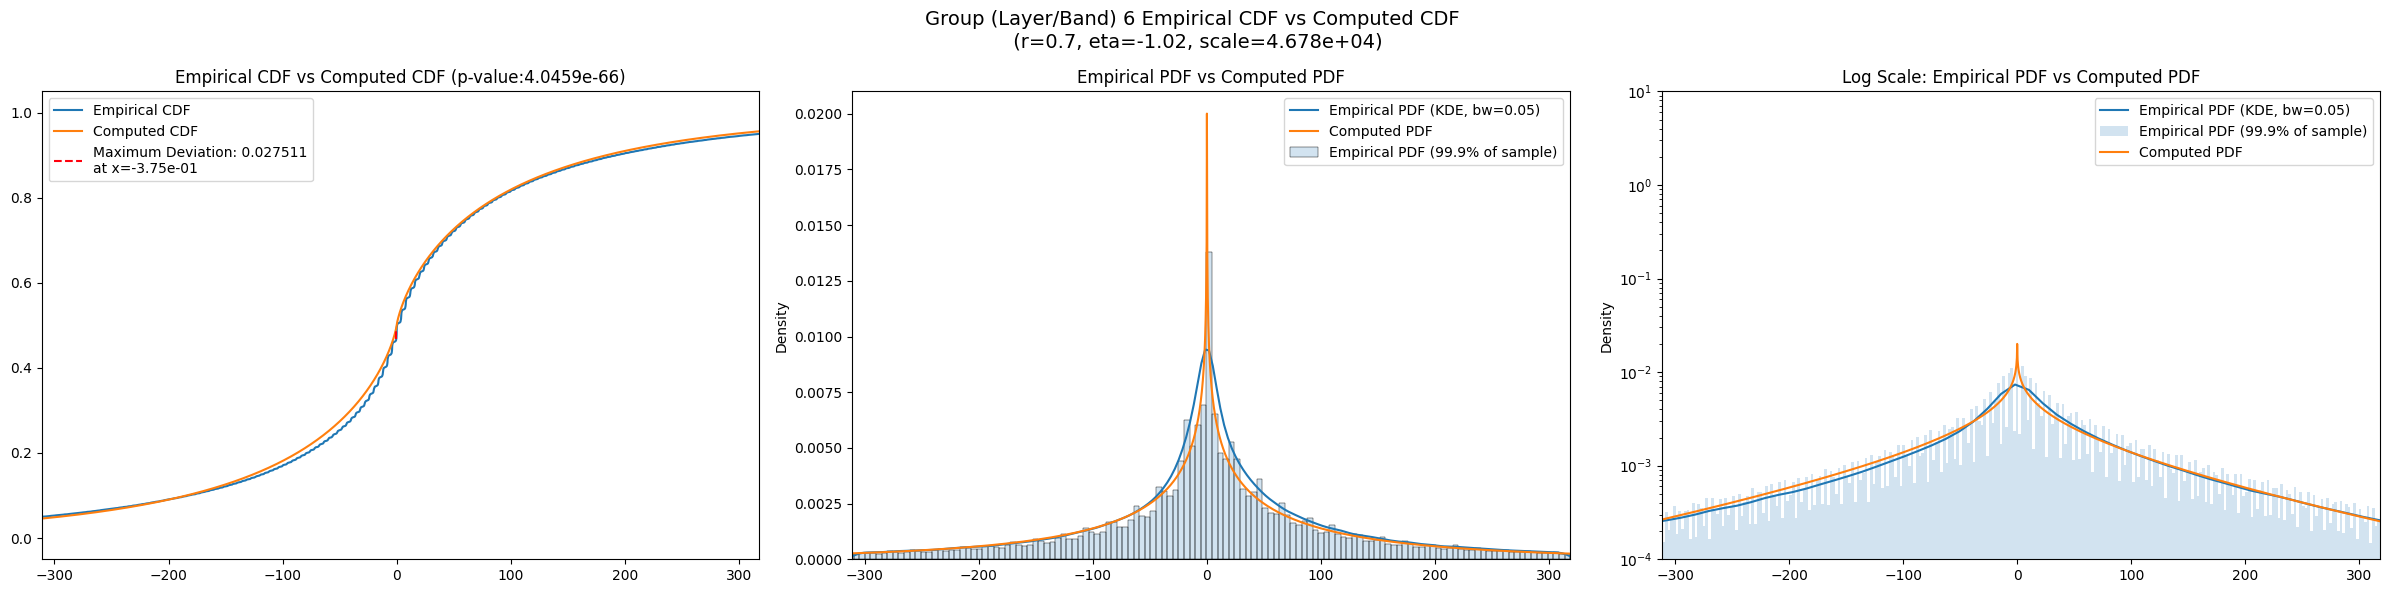

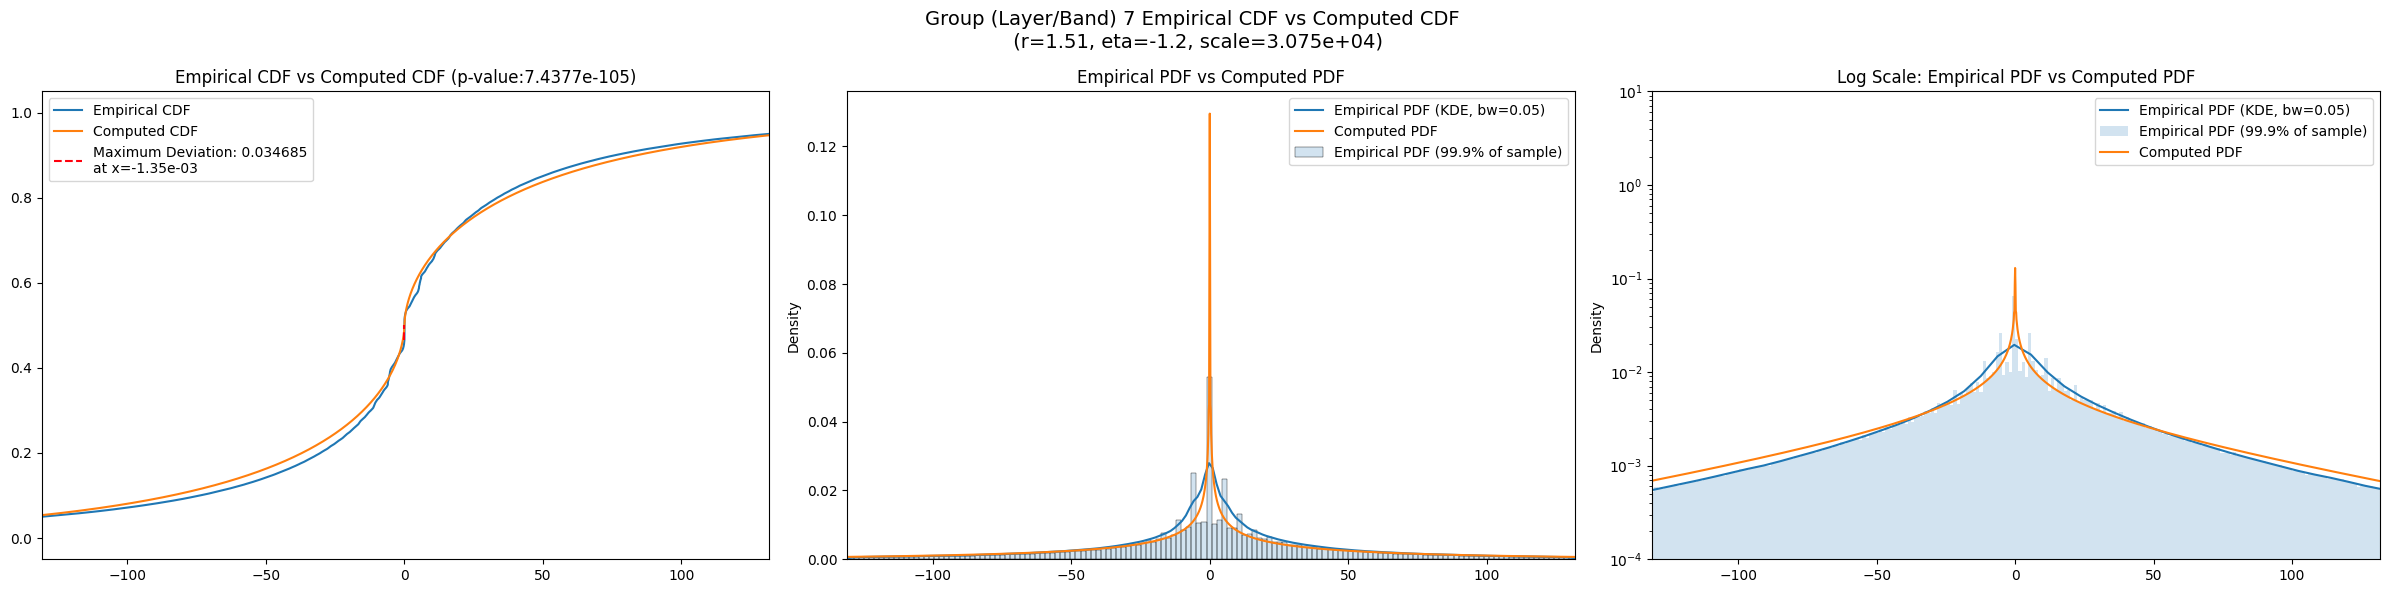

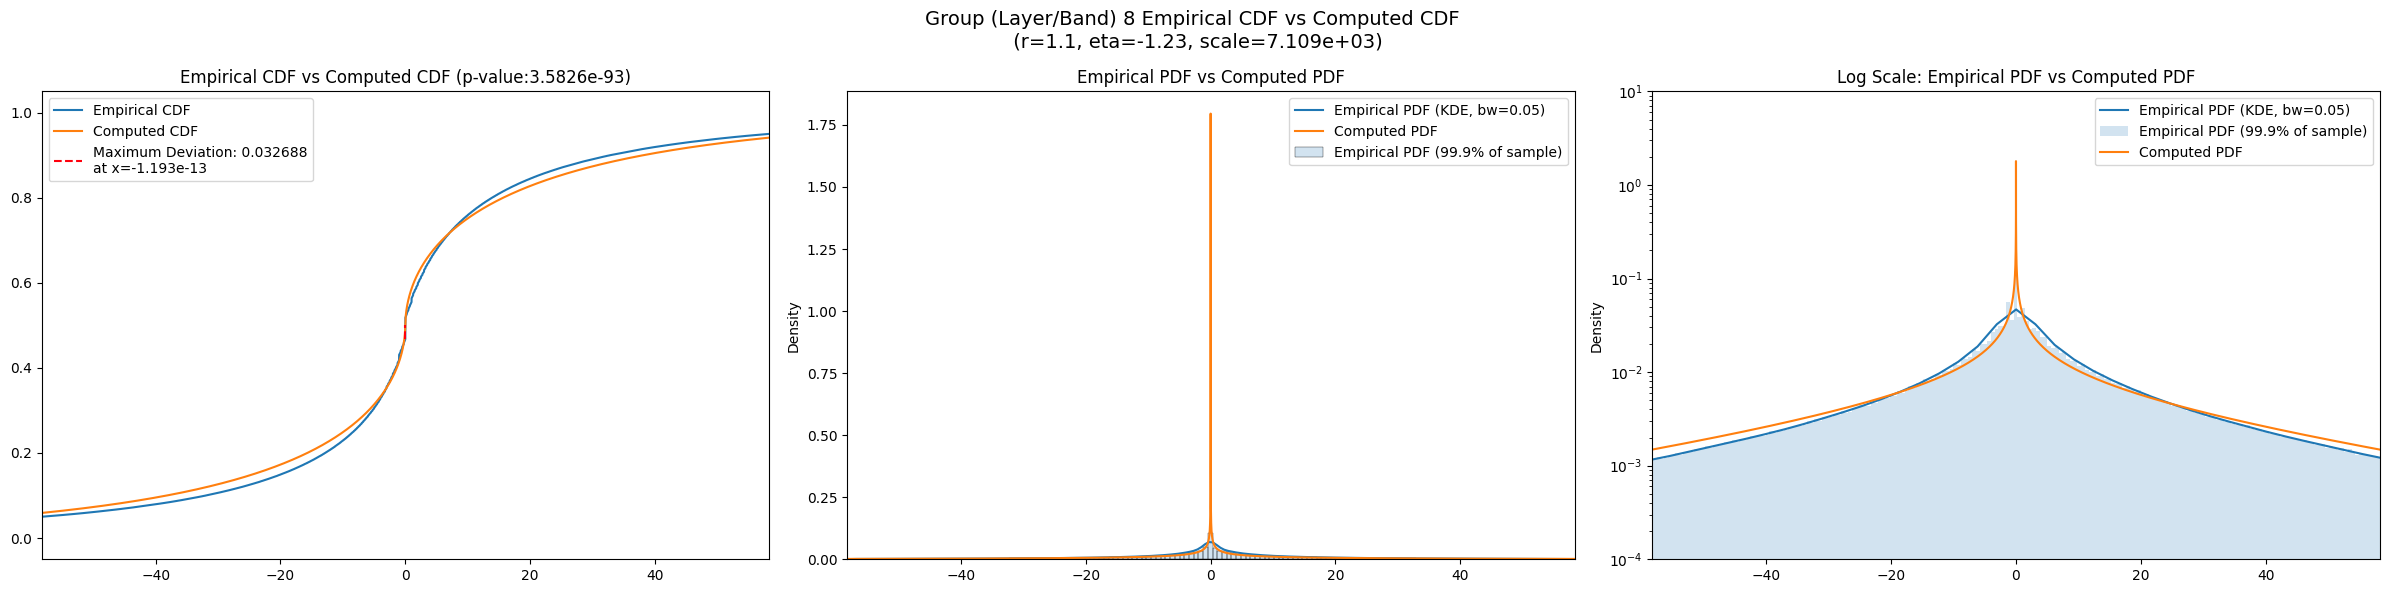

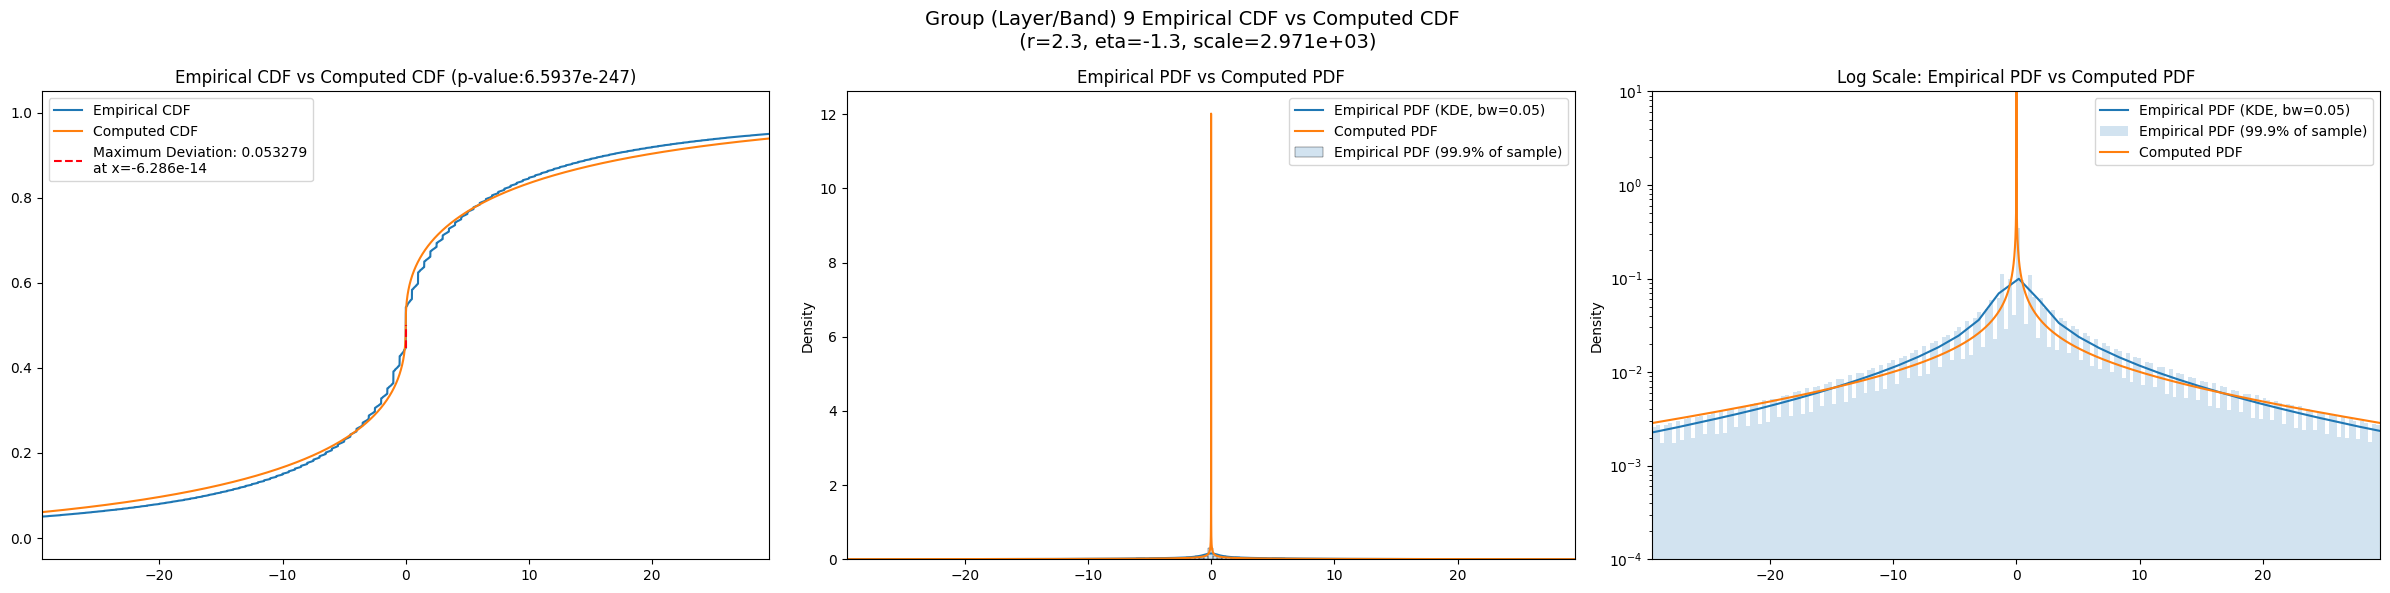

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      3.005896e+07  2.753840e+07  3.271191e+07   0.729961    0.399370   
3      5.665110e+06  5.395799e+06  5.944192e+06   1.467750    1.230583   
4      1.100174e+06  1.039448e+06  1.163045e+06   2.750551    2.309108   
5      2.109796e+05  1.972241e+05  2.252361e+05   4.704504    4.043722   
6      4.082841e+04  3.771386e+04  4.411157e+04   7.281816    6.115109   
7      8.083446e+03  7.364765e+03  8.848112e+03  10.622059    8.626104   
8      1.791469e+03  1.614135e+03  1.980054e+03  13.650112   11.173287   
9      4.776892e+02  4.297687e+02  5.292324e+02  14.636528   11.965131   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        1.080867         2446.0             0.058427        0.4          2.9   
3        1.719616         9784.0             0.046456        0.4          0.8   
4        3.245366        39136.0             0.031972        0.4         -0.1   
5        5.443765       156544.0             0.025276        0.5         -0.8   
6        8.737838       626176.0             0.027652        0.6         -1.0   
7       13.357651      2504704.0             0.034650        1.3         -1.2   
8       16.722440     10018816.0             0.032660        0.8         -1.2   
9       17.953781     40075264.0             0.053230        2.1         -1.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      4768.31000              0.063022          6.881480e-09   
3      ...      1858.12000              0.055630          9.275400e-27   
4      ...       738.84300              0.055409         7.062480e-105   
5      ...       269.83900              0.065934          0.000000e+00   
6      ...        98.34880              0.075892          0.000000e+00   
7      ...        38.02550              0.077904          0.000000e+00   
8      ...        16.46500              0.077635          0.000000e+00   
9      ...         7.73278              0.084341          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2          4803.7500             0.062917         7.345390e-09  3909.96000   
3          1895.1800             0.046228         1.313060e-18  1403.58000   
4           633.4430             0.033026         1.606370e-37   530.44300   
5           232.0810             0.039736        3.301430e-215   188.02100   
6            84.0095             0.050482         0.000000e+00    67.17970   
7            31.9740             0.054372         0.000000e+00    25.28220   
8            14.1242             0.052339         0.000000e+00    11.03520   
9             6.3689             0.063051         0.000000e+00     4.99002   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.058330   1.123890e-07          1.068288e-07  
3           0.046587   6.836410e-19          8.851388e-19  
4           0.038461   9.770490e-51          5.624416e-34  
5           0.044494  9.729570e-270          7.457502e-87  
6           0.054075   0.000000e+00          0.000000e+00  
7           0.057089   0.000000e+00          0.000000e+00  
8           0.054269   0.000000e+00          0.000000e+00  
9           0.065546   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.058427                 0.027391          0.058419   
3                 0.046456                 0.013713          0.046445   
4                 0.031972                 0.006861          0.031409   
5                 0.025276                 0.003431          0.025209   
6                 0.027652                 0.001716          0.027457   
7                 0.034650                 0.000858          0.034650   
8                 0.032660                 0.000429          0.032660   
9                 0.053230                 0.000215          0.053230   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.063022             0.062917       0.058330  
3                  0.055630             0.046228       0.046587  
4                  0.055409             0.033026       0.038461  
5                  0.065934             0.039736       0.044494  
6                  0.075892             0.050482       0.054075  
7                  0.077904             0.054372       0.057089  
8                  0.077635             0.052339       0.054269  
9                  0.084341             0.063051       0.065546

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            3.005896e+07          0.058419    0.41      2.80  83168.052034   
3            5.665110e+06          0.046445    0.38      0.90  32626.350621   
4            1.067176e+06          0.031409    0.46     -0.30  88303.427171   
5            2.109796e+05          0.025209    0.50     -0.83  67285.233488   
6            3.731203e+04          0.027457    0.70     -1.02  46780.730632   
7            7.331527e+03          0.034650    1.51     -1.20  30750.380032   
8            1.791469e+03          0.032660    1.10     -1.23   7108.964953   
9            4.591987e+02          0.053230    2.30     -1.30   2971.402850   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                      0.0  
6                    125.0  
7                    100.0  
8                      0.0  
9                     25.0

In [21]:
eng.quit()